In [9]:
import simpy
import numpy as np
import itertools
import matplotlib.pyplot as plt
import time
import argparse
import gym
import numpy as np
import random

In [10]:
def Qnetwork(previous_state, _state, reward, _q_table, total_state):
    if _state == None:
        _state = previous_state

    pre_state = 0
    for idx, element in enumerate(total_state):
        if (np.array(element) == previous_state).all():
            pre_state = idx

    state = 0
    for idx, element in enumerate(total_state):
        if (np.array(element) == _state).all():
            state = idx

    # Init arbitary values
    if np.any(_q_table == None):
        q_table = np.zeros([6 * 6 * 6 * 2 * 9 * 11, 2])
    else:
        q_table = _q_table

    # Hyperparameters
    alpha = 0.1    
    gamma = 0.5
    epsilon = 0.1

    if random.uniform(0, 1) < epsilon:
        # Check the action space
        action = random.randint(0, 1)
    else:
        # Check the learned values
        action = np.argmax(q_table[pre_state])

    # next_state, reward, done, info = env.step(action)

    
    old_value = q_table[pre_state, action]
    next_max = np.max(q_table[state])
    
    # Update the new value
    new_value = old_value + alpha * (reward + gamma * next_max - old_value)
    q_table[pre_state, action] = new_value

    return previous_state, action, q_table

In [11]:
parser = argparse.ArgumentParser()
parser.add_argument("--old-state-1", default=None)
parser.add_argument("--old-state-2", default=None)
parser.add_argument("--old-state-reject", default=None)
parser.add_argument("--q-table-1", default=None)
parser.add_argument("--q-table-2", default=None)
parser.add_argument("--q-table-reject", default=None)
parser.add_argument("--total-state", default=[])
parser.add_argument("--penalty", default=0, type=float)
args, _ = parser.parse_known_args()

if len(args.__dict__) <= 1:
    # No arguments or subcommands were given.
    parser.print_help()
    parser.exit()

In [12]:
# create total_state
for S1 in range(6):
    for S2 in range(6):
        for S3 in range(6):
            for S4_switch in range(2):
                for S5 in range(9):
                    for S6 in range(11):
                        args.total_state.append([S1, S2, S3, S4_switch, S5, S6])  

In [13]:
start = time.time()

maxTime = 10
warm_up = 0
gohome_for_s5 = 0.1
numTry = 10
obs_timeRate = 1
obsForWarmup_timeRate = 1000  # warm up test용 통계치 산출 구간
#doTabu = False  # True:Tabu 적용, False: Tabu 미적용
testIntern = [0, 0, 0, 0, 0, 0]

S4_switch = 0
reprocessRate = 0.1

users = []
users_afterWarmup = []
users_gohome = []
users_completed = []
users_servedByIntern = []
users_rework=[]
users_fail=[]

servers = []  # 서버리스트: S1~S6
servers_intern = []

q1 = []
q2 = []
q3 = []
q41 = []
q42 = []
q5 = []
q6 = []

revenues = []

revenue = 1000
intern_cost = 100
rework_cost = 300
fail_cost = 500

# name, capacity, service speed, maxQueue
s_info = []
s_info.append(['S1', 1, 12.0, 5]) 
s_info.append(['S2', 1, 8.0, 5])
s_info.append(['S3', 1, 6.0, 5])
s_info.append(['S4', 1, 6.0, 5])
s_info.append(['S5', 1, 8.0, 8])
s_info.append(['S6', 1, 14.0, 10])

s_intern_info = []
s_intern_info.append(['S_intern 4', 0, 3.0, s_info[3][3]])

In [14]:
class ServiceCounter(object):  # service couter class parameter생성은 아래에서

    def __init__(self, env, name, cap, service_speed, maxQueue):
        self.env = env
        self.name = name
        self.capacity = cap
        self.res = simpy.Resource(self.env, capacity=cap)
        self.service_speed = service_speed
        self.maxQueue = maxQueue

    def isEmpty(self):
        # print('Empty??')
        # print(len(self.res.users))
        if (len(self.res.users) < self.capacity):  # user함수의 초기값은 0(simpy)
            # print('Yes')
            return True  # 빈자리가 있다
        else:
            # print('No')
            return False  # 빈자리가 없다

In [15]:
class User(object):
    def __init__(self, num):
        self.num = num
        self.isActive = False  # 활성화 유무

    def setCounter(self, counter):
        self.currentCounter = counter

    def goingHome(self, env, serverName):
        # warm_up 이상일 떄만 추가
        if (env.now >= warm_up):
            users_gohome.append(self)
        print(env.now, '### customer {} waited for {} and WENT BACK HOME'.format(self.num, serverName))
        self.isActive = False

    ### Server 4B에 의한 서비스 -------------------------------------------------------------------------    
    def ServeByIntern(self, env):
        if (env.now >= warm_up):
            users_servedByIntern.append(self)
            
    ### 투입에서 Server1로 이동 -------------------------------------------------------------------------
    def run_stage_1(self, env, servers):

        self.isActive = True

        ### Server1 자리가 비어 있으면 서비스 진행
        if (servers[0].isEmpty()):
            self.setCounter(servers[0])

        ### servet1의 자리가 꽉 차 있을때,
        else:
            ### Q의 모든 자리가 다 차있으면 집에 간다
            if (len(q1) >= servers[0].maxQueue):
                self.goingHome(env, servers[0].name)
                users_gohome.append(self)
                return
            
            ### 아니면 Server1에서 대기한다.
            else:

                self.setCounter(0)
                q1.append(self)  # selt: num, currentCount 정보 모두를 의미
                
        ### 서비스 정의
        if (self.currentCounter != 0):
            with self.currentCounter.res.request() as request:
                t_arrival = env.now

                yield request

                yield env.timeout(np.random.exponential(1. / self.currentCounter.service_speed))

                t_depart = env.now
                args.penalty += t_depart - t_arrival

                ### 비어있지 않으면
                if (len(q1) > 0):
                    env.process(q1.pop(0).run_stage_1(env, servers))

                _state = [len(q1), len(q2), len(q3), S4_switch, len(q5), len(q6)]
                reward = 1000 - (t_depart - t_arrival) 
                args.old_state_1, action, args.q_table_1 = Qnetwork(_state, args.old_state_1, reward, args.q_table_1, total_state=args.total_state)

                env.process(self.run_stage_2(env, servers, action)) ### Stage2로 이동
    

    ### Server1에서 Server2 or Server3로 이동 -----------------------------------------------------------------------    
    def run_stage_2(self, env, servers, action):  
        
        ### Action이 0으로 결정되면 Server2로 이동
        if action == 0:  
            
            ### S2의 자리가 비어있으면 가서 수행  
            if (servers[1].isEmpty()):  
                self.setCounter(servers[1])  
            else:  
                ### 자리가 없으면 집으로 감 
                if (len(q2) >= servers[1].maxQueue):  
                    self.goingHome(env, servers[1].name)
                    return  
                
                ### 자리가 있으면 서비스 받음  
                else:  
                    self.setCounter(0)  
                    q2.append(self)  

        ### action이 1로 결정되면 Server3로 보냄  
        else:  
            if (servers[2].isEmpty()):  
                self.setCounter(servers[2])  
            else:  
                ### 자리가 없으면 집으로  
                if (len(q3) >= servers[2].maxQueue):  
                    self.goingHome(env, servers[2].name)
                    return
                
                ### 자리가 있으면 서비스 받음
                else:  
 
                    self.setCounter(0)  
                    q3.append(self)  

        ### 서비스 정의  
        if (self.currentCounter != 0):  
            with self.currentCounter.res.request() as request:  
                t_arrival = env.now  
 
                yield request  
 
                yield env.timeout(np.random.exponential(1. / self.currentCounter.service_speed))  

                t_depart = env.now  
                args.penalty += t_depart - t_arrival  

                if (self.currentCounter.name == 'S2'):  
                    if (len(q2) > 0):   
                        env.process(q2.pop(0).run_stage_2(env, servers, action))  

                    _state = [len(q1), len(q2), len(q3), S4_switch, len(q5), len(q6)]  
                    reward = 1000-(t_depart - t_arrival)  
                    args.old_state_2, action, args.q_table_2 = Qnetwork(_state, args.old_state_2, reward, args.q_table_2, total_state=args.total_state)
                    self.preCounter = 2  
                    env.process(self.run_stage_3(env, servers, action)) 

                elif (self.currentCounter.name == 'S3'):  
                    if (len(q3) > 0):  
 
                        env.process(q3.pop(0).run_stage_2(env, servers, action))  
                    self.preCounter = 3  
                    env.process(self.run_stage_3(env, servers, action))
                    

    ### Server2에서 Server4a or Server4b로 이동 -----------------------------------------------------------------------    
    def run_stage_3(self, env, servers, action):  

        S4_switch == action
        
        if (self.preCounter ==2) : ### server2로 부터 옴            

            if action == 0:
                
                ### Server4a의 자리가 비어있으면 가서 수행  
                if (servers[3].isEmpty()):  
                    self.setCounter(servers[3])  
                else:  
                    ### Server2의 Maxque가 꽉 차있으면 Server1으로 Return  
                    if (len(q41) >= servers[3].maxQueue):  
                        self.goingHome(env, servers[3].name)
                        return
                   
                    ### Server4a Maxque가 비어 있으면 Server2에서 대기
                    else:  

                        self.setCounter(0) 
                        q41.append(self)   

            else:                
                ### Server4b의 자리가 비어있으면 가서 수행  
                if (servers_intern[0].isEmpty()):  
                    self.setCounter(servers_intern[0])  
                else:  
                    ### Server4b의 Maxque가 꽉 차있으면 Server1으로 Return  
                    if (len(q42) >= servers_intern[0].maxQueue):  
                        self.goingHome(env, servers_intern[0].name)
                        return
                   
                    ### Server4b Maxque가 비어 있으면 Server2에서 대기
                    else:  

                        q42.append(self)  
                        self.setCounter(0)  
                        self.ServeByIntern(env) 
                        
        
            ### 서비스 정의
            if (self.currentCounter != 0):  
                with self.currentCounter.res.request() as request:  
                    t_arrival = env.now  

                    yield request  
  
                    yield env.timeout(np.random.exponential(1. / self.currentCounter.service_speed))  

                    t_depart = env.now  

                    ### 비어 있지 않으면
                    if (self.currentCounter.name == 'S4'):  
                        if (len(q41) > 0):  
  
                            env.process(q41.pop(0).run_stage_3(env, servers, action))  
                            
                        _state = [len(q1), len(q2), len(q3), S4_switch, len(q5), len(q6)]  
                        reward = 1000-(t_depart - t_arrival) 
                        args.old_state_2, action, args.q_table_2 = Qnetwork(_state, args.old_state_2, reward, args.q_table_2, total_state=args.total_state)
                        env.process(self.run_stage_5(env, servers))  

                    else:  
                        if (len(q42) > 0):  

                            env.process(q42.pop(0).run_stage_3(env, servers, action)) 
                            
                        _state = [len(q1), len(q2), len(q3), S4_switch, len(q5), len(q6)]  
                        reward = 1000-(t_depart - t_arrival) - intern_cost
                        args.old_state_2, action, args.q_table_2 = Qnetwork(_state, args.old_state_2, reward, args.q_table_2, total_state=args.total_state)


                        env.process(self.run_stage_5(env, servers))                        
                        
        if (self.preCounter == 3) : ### Server3에서 부터 옴

            ### Server5의 자리가 비어있으면 가서 수행  
            if (servers[4].isEmpty()):
                self.setCounter(servers[4])

            ### Server5의 Maxque가 꽉 차있으면 집으로 감        
            else: 
                if (len(q5) >= servers[4].maxQueue):
                    self.goingHome(env, servers[4].name)
                    return

                ### Server5 Maxque가 비어 있으면 Server3에서 대기            
                else:

                    self.setCounter(0)
                    q5.append(self)  # selt: num, currentCount 정보 모두를 의미
        
        
            ### 서비스 정의         
            if (self.currentCounter != 0):
                with self.currentCounter.res.request() as request:
                    t_arrival = env.now

                    yield request

                    yield env.timeout(np.random.exponential(1. / self.currentCounter.service_speed))

                    t_depart = env.now
 
                    ### 비어 있지 않으면
                    if (len(q5) > 0):

                        env.process(q5.pop(0).run_stage_4(env, servers, action)) ### Stage4로 이동

                        
                    _state = [len(q1), len(q2), len(q3), S4_switch, len(q5), len(q6)]
                    reward = 1000 - (t_depart - t_arrival)
                    args.old_state_reject, action, args.q_table_reject = Qnetwork(_state, args.old_state_reject, reward, args.q_table_reject, total_state=args.total_state)
                    env.process(self.run_stage_4(env, servers, action))  ### Stage4로 이동
              
            
    ### Server5에서 Reject or S2 rework 보내기 --------------------------------------------------------------------------
    def run_stage_4(self, env, servers, action):
        
        ### 90%는 Stage5(Server6)으로 보냄
        r = np.random.random()  
        if r > reprocessRate:  
            env.process(self.run_stage_5(env, servers))  
            return
        
        ### 10%는 reprocess 대상임
        else :
            ### action이 0으로 결정되면 Server2로 Rework 보냄
            if action ==0:
                ### server2가 비어있으면 Server2로가서 Rework 진행
                if (servers[1].isEmpty()):
                    self.setCounter(servers[1])
                    users_rework.append(self)
            
                ### Server2의 Maxque가 꽉 차 있으면
                else:
                    if (len(q2) >= servers[1].maxQueue):
                        self.goingHome(env, servers[1].name)
                        users_fail.append(self)
                        return
                    ### Server2의 Maxwue가 비어 있으면 Server2에서 대기
                    else:

                        self.setCounter(0)
                        q2.append(self)
                    
            ### Action값이 1로 결정되면 Reject함
            else:
                self.goingHome(env, servers[4].name)
                users_fail.append(self)

        ### 서비스 정의 
        if (self.currentCounter != 0):  
            with self.currentCounter.res.request() as request:  
                t_arrival = env.now  

                yield request  
 
                yield env.timeout(np.random.exponential(1. / self.currentCounter.service_speed))  

                t_depart = env.now  

                ### Rework의 경우 -300의 비용 소요
                if action ==0:
                    _state = [len(q1), len(q2), len(q3), S4_switch, len(q5), len(q6)]  
                    reward = 1000 - (t_depart - t_arrival) - 300
                    args.old_state_reject, action, args.q_table_reject = Qnetwork(_state, args.old_state_reject, reward, args.q_table_reject, total_state=args.total_state)
                    env.process(self.run_stage_2(env, servers, action))                     
                
                ### Reject의 경우 -500의 비용 소요
                else:
                    _state = [len(q1), len(q2), len(q3), S4_switch, len(q5), len(q6)]
                    reward = 1000 - (t_depart - t_arrival) - 500
                    args.old_state_reject, action, args.q_table_reject = Qnetwork(_state, args.old_state_reject, reward ,args.q_table_reject, total_state=args.total_state)
                    
                    
    ### Server6에서 처리 후 종료 -----------------------------------------------------------------------------------------           
    def run_stage_5(self, env, servers):  
 
        ### S6의 자리가 비어있으면 가서 수행  
        if (servers[5].isEmpty()):  
            self.setCounter(servers[5])  
        else:
            ### Server6의 자리가 꽉 찼으면 집으로 감
            if (len(q6) >= servers[5].maxQueue):
                self.goingHome(env, servers[5].name)
                return
            
            ### 모든 자리가 차 있으면 큐에 가서 대기  
            else:  
                self.setCounter(0)  
                q6.append(self)  

        ### 서비스 정의 
        if (self.currentCounter != 0):  
            with self.currentCounter.res.request() as request:  
                t_arrival = env.now  
                yield request  
                yield env.timeout(np.random.exponential(1. / self.currentCounter.service_speed))  
                t_depart = env.now  

                ### 비어 있으면 
                if (len(q6) > 0):  
                    env.process(q6.pop(0).run_stage_5(env, servers))  

                if (env.now >= warm_up):  
                    users_completed.append(self)  
                self.isActive = False  

In [16]:
def cafe_run(env, servers):  
    i = 0  
    while True:  
        i += 1  
        users.append(User(i))  

        # warmup 시간 이후라면 추가  
        if (env.now >= warm_up):  
            users_afterWarmup.append(User(i))  

        yield env.timeout(generate_interarrival())  
        print(env.now, 'WELCOME customer {}'.format(i))
        env.process(users[i - 1].run_stage_1(env, servers))
        #env.process(users[i-1].run_stage_1(env, servers))  


    #    env.process(customer(env, users[i-1], servers))

def generate_interarrival():  
    return np.random.exponential(1. / 10.0)   

obs_times = []  
activeUsers = []  

#clear 필요  
avg_activeUsers_inTime = []  
avg_comUsers_inTime = []  

def observeWarmupTime(env, servers):  
    i = 0  
    last_uc = []  
    while True:  
        i += 1  
        yield env.timeout(obsForWarmup_timeRate)  

        # i ~ i-1 까지의 평균 숫자  
        aList_inTime = activeUsers[len(activeUsers) - obsForWarmup_timeRate:]  
        avg_activeUsers_inTime.append(sum(aList_inTime) / len(aList_inTime))  
        print('ACTIVE LIST in TIME: {}'.format(aList_inTime))  

        # 나간 사람 수  
        last_uc.append(len(users_completed))  
        # 만약 처음이면 그냥 넣어  
        if (i == 1):  
            avg_comUsers_inTime.append(last_uc[0] / obsForWarmup_timeRate)  
            # avg_comUsers_inTime.append(len(users_completed))  
        # 처음이 아니라면 토탈 값에서 이전 값 뺴기  
        else:  
            avg_comUsers_inTime.append((last_uc[-1] - last_uc[-2]) / obsForWarmup_timeRate)  
            # last = len(users_completed) - last_uc[-1]  
            # avg_comUsers_inTime.append(last)  
            # last = len(users_completed) - avg_comUsers_inTime[-1]  
            # avg_comUsers_inTime.append(last)  
        print('COM LIST in TIME: {}'.format(avg_comUsers_inTime[-1]))  
        
def warmup(env, servers):  
    yield env.timeout(warm_up)  
    print('=======================')  
    print('WARMUP TIME')  
    print('=======================')  

    for i in users:  
        if (i.isActive):  
            users_afterWarmup.append(i)  

    env.process(observe(env, servers))  


q_length1 = []  
q_length2 = []  
q_length3 = []  
q_length4 = []
q_lengthIntern = []
q_length5 = []  
q_length6 = [] 

# ------------------------------------------------------------------------------#                   
def observe(env, servers):  
    while True:  

        obs_times.append(env.now)  

        q_length1.append(len(q1))  
        q_length2.append(len(q2))  
        q_length3.append(len(q3))  
        q_length4.append(len(q41))
        q_lengthIntern.append(len(q42))
        q_length5.append(len(q5))  
        q_length6.append(len(q6))  

        n = 0  
        for i in users:  
            if (i.isActive):  
                n += 1  
        activeUsers.append(n)  

        yield env.timeout(obs_timeRate)  
        
        
def clearAllData():  
    for i in servers:  
        del i  
    servers.clear()  

    for i in servers_intern:  
        del i  
    servers_intern.clear()  

    users.clear()  
    users_gohome.clear()  
    users_completed.clear()  
    users_servedByIntern.clear()  
    users_afterWarmup.clear()  

    q1.clear()  
    q2.clear()  
    q3.clear()  
    q41.clear()  
    q42.clear()  
    q5.clear()
    q6.clear()  
# ------------------------------------------------------------------------------# 

total_num_profit = []  
total_try = []  
all_bestCandidates_profit = []  
all_bestCandidates = []  
total_candidate = []  

def calProfit(element):  
    np.random.seed(1)  
    env = simpy.Environment()  

    # Service 생성  
    for j in s_info:  
        servers.append(ServiceCounter(env, j[0], j[1], j[2], j[3]))  

    n = 0  
    for j in s_intern_info:  
        if (element[n] != 0):  
            servers_intern.append(ServiceCounter(env, j[0], element[n], j[2], j[3]))  
        else:  # Capacity가 0이 되면 오류  
            servers_intern.append(ServiceCounter(env, j[0], element[n] + 0.001, j[2], j[3]))  
        n += 1  
    
    env.process(cafe_run(env, servers))  
    env.process(warmup(env, servers))  
    if (warmup == 0):  
        env.process(observeWarmupTime(env, servers))  

    env.run(until=maxTime)  

    print('Over')  
    print('{} : total customers'.format(len(users_afterWarmup) - 1))  # 마지막 유저는 입장하지 않았기 때문에 카운트하지 않  
    # for i in users_afterWarmup:  
    # print('     user: {}'.format(i.num))  

    print('{} : full experienced customers'.format(len(users_completed)))  
    print('{} : go home customers'.format(len(users_gohome)))  

    # 실험 결과값 저장  
    tot_intern_cost = len(users_servedByIntern) * intern_cost  
    tot_rework_cost = len(users_rework) * rework_cost
    tot_reject_cost = len(users_fail) * fail_cost
    tot_sales = len(users_completed) * revenue  

    profit = tot_sales - tot_intern_cost - tot_rework_cost - tot_reject_cost

    print('profit: {} '.format(profit))  
    print('sales: {} '.format(tot_sales)) 
    print('intern cost: {} '.format(tot_intern_cost)) 
    print('rework cost: {} '.format(tot_rework_cost)) 
    print('reject cost: {} '.format(tot_reject_cost)) 
    
    usersInServer = 0  
    for i in servers:  
        if (not (i.isEmpty())):  
            usersInServer += 1  
    for i in servers_intern:  
        if (not (i.isEmpty())):  
            usersInServer += 1  
    print('num users in servers: {}'.format(usersInServer))  
    print('num users in Queues : {} : (q1= {}, q2= {}, q3= {}, q41= {}, q42= {}, q5= {}, q6= {})'.format(  
        len(q1) + len(q2) + len(q3) + len(q41) +  
        len(q42) + len(q5) + len(q6), len(q1), len(q2), len(q3), len(q41),  
        len(q42), len(q5), len(q6)))  

    
    # 실험 데이터 클리어  
    clearAllData()  
    return profit

if __name__ == "__main__":  

    # initialize reinforcement learning parameters  
    reward = 0  

    calProfit(testIntern)  

    print('Last active users: {}'.format(activeUsers[-1]))  
    end = time.time()  
    print('Total Running Time: {} sec'.format(end - start))  

    avg_q = []  
    avg_q.append(sum(q_length1) / len(q_length1))  
    avg_q.append(sum(q_length2) / len(q_length2))  
    avg_q.append(sum(q_length3) / len(q_length3))  
    avg_q.append(sum(q_length4) / len(q_length4))  
    avg_q.append(sum(q_length5) / len(q_length5))  
    avg_q.append(sum(q_length6) / len(q_length6))  
    print('Average Q Values : q1= {}, q2= {}, q3= {}, q4= {}, q5= {}, q6: {}'.format(avg_q[0], avg_q[1], avg_q[2], avg_q[3], avg_q[4], avg_q[5]))  
    print('Average number of active users: {}'.format(avg_activeUsers_inTime))  
    print('number of completed users in time: {}'.format(avg_comUsers_inTime)) 

WARMUP TIME
0.05396058372591855 WELCOME customer 1
0.18137310902724899 WELCOME customer 2
0.20198457243545703 WELCOME customer 3
0.2525298266065319 WELCOME customer 4
0.3681177975774741 WELCOME customer 5
0.422126902221917 WELCOME customer 6
0.4372541941801106 WELCOME customer 7
0.5985709644641456 WELCOME customer 8
0.823576551061399 WELCOME customer 9
0.8339290859923532 WELCOME customer 10
1.1506749739123738 WELCOME customer 11
1.6004060535825506 WELCOME customer 12
1.713986246444569 WELCOME customer 13
1.7816296411014247 WELCOME customer 14
1.9019464072957422 WELCOME customer 15
1.9742841852203736 WELCOME customer 16
2.2080038217160682 WELCOME customer 17
2.3469586278371084 WELCOME customer 18
2.4446881004005574 WELCOME customer 19
2.487597049625427 WELCOME customer 20
2.713824141833088 WELCOME customer 21
2.7260122057281224 WELCOME customer 22
2.7857799313487486 WELCOME customer 23
2.8128331922548284 WELCOME customer 24
3.046529648032015 WELCOME customer 25
3.0907326656534346 WELCOM

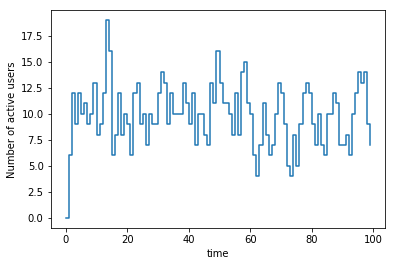

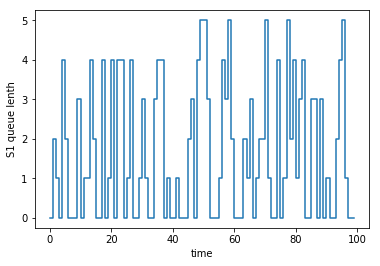

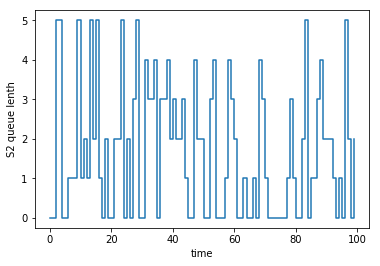

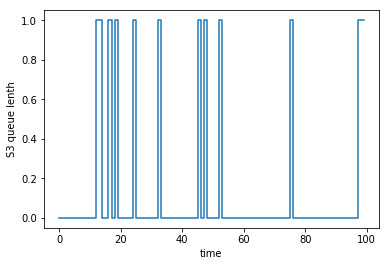

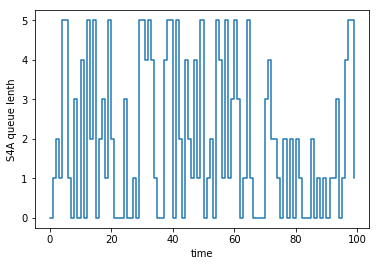

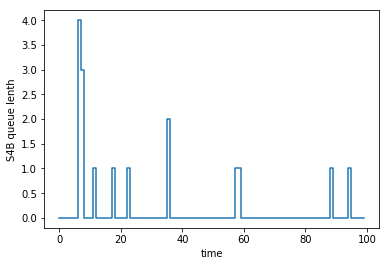

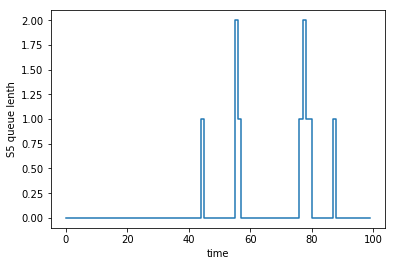

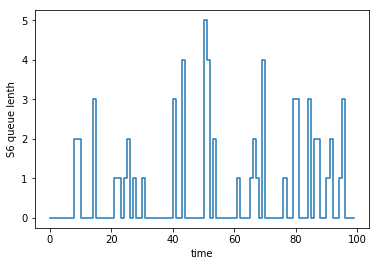

In [38]:
    plt.figure()
    plt.step(obs_times, activeUsers, where='post')
    plt.xlabel('time')
    plt.ylabel('Number of active users')

    plt.show()

    plt.figure()
    plt.step(obs_times, q_length1, where='post')
    plt.xlabel('time')
    plt.ylabel('S1 queue lenth')
    plt.show()

    plt.figure()
    plt.step(obs_times, q_length2, where='post')
    plt.xlabel('time')
    plt.ylabel('S2 queue lenth')
    plt.show()

    plt.figure()
    plt.step(obs_times, q_length3, where='post')
    plt.xlabel('time')
    plt.ylabel('S3 queue lenth')
    plt.show()

    plt.figure()
    plt.step(obs_times, q_length4, where='post')
    plt.xlabel('time')
    plt.ylabel('S4A queue lenth')
    plt.show()

    plt.figure()
    plt.step(obs_times, q_lengthIntern, where='post')
    plt.xlabel('time')
    plt.ylabel('S4B queue lenth')
    plt.show()

    plt.figure()
    plt.step(obs_times, q_length5, where='post')
    plt.xlabel('time')
    plt.ylabel('S5 queue lenth')
    plt.show()

    plt.figure()
    plt.step(obs_times, q_length6, where='post')
    plt.xlabel('time')
    plt.ylabel('S6 queue lenth')
    plt.show()


In [47]:
from vispy import app, gloo

c = app.Canvas(keys='interactive')


@c.connect
def on_draw(event):
    """ a callback function called when the canvas needs to be refreshed """
    gloo.set_clear_color((0.2, 0.4, 0.6, 1.0))
    gloo.clear()

c.show()
app.run()

VispyWidget(height=600, width=800)